# Midterm project: python 實作數獨解題機

## 概念：  
以往使用程式解數獨，在填入<span style="color:red">每一格</span>的數字時都需要使用<span style="color:red">多個迴圈</span>檢查同個row, column, box中是否已經有<span style="color:red">相同的數字</span>被使用過  
然而python並不擅長迴圈計算，再配上多層遞迴的呼叫，傳統的計算方式會耗費大量的時間
## 解決方式：
利用python中<span style="color:red">set()</span>的功能<span style="color:red">降低</span>數獨在遞迴求解時的<span style="color:red">時間複雜度</span>
## 方法：
利用三組set()--**R, C, B**去追蹤各個row, column, box(九宮格)尚未被選取的值。  
1. R是一個list，裡面存著R[0], R[1], ..., R[8]共9個set，分別代表第0, 1, ..., 8 個 <span style="color:red">*row* 尚未被使用過</span>的數字  
2. C是一個list，裡面存著C[0], C[1], ..., C[8]共9個set，分別代表第0, 1, ..., 8 個 <span style="color:red">*column* 尚未被使用過</span>的數字  
3. B是一個list，裡面存著B[0], B[1], ..., B[8]共9個set，分別代表第0, 1, ..., 8 個 <span style="color:red">*box* 尚未被使用過</span>的數字  

如同下圖所示：  
可以發現只要有了這些set的幫助，就能**直接省略**在填入數字時**重複檢查**row, column, box內是否有重複數字的步驟。  
例如目前要填入<span style="color:red">第(3, 5)格</span>內的數字，就只需要取<span style="color:red">R[3], C[5], B[4]</span>這三個set的<span style="color:red">交集</span>，就能夠知道能夠填入的數字有哪些。  
利用這種方式，在進行每一格的運算時，就能夠完全去除for迴圈的使用，有效提升程式效能。
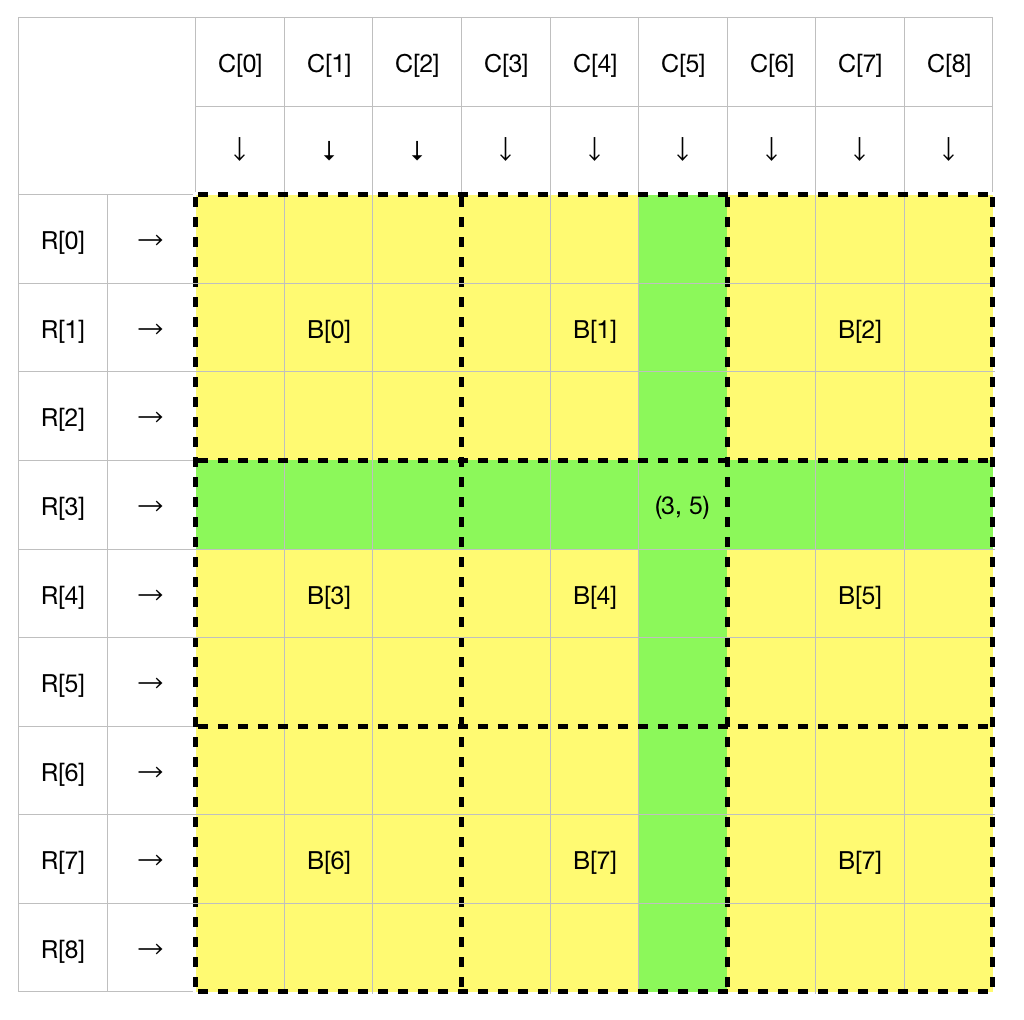

## 實作：
### Input: 
有81個entry的numpy array代表<span style="color:red">*數獨題目*</span>，array中第i個值代表在第(i/9) row, (i%9) column的位置的數字，若值為-1則代表此格為空白。
### Output:
有81個entry的numpy array代表<span style="color:red">*數獨解答*</span>，array中第i個值代表在第(i/9) row, (i%9) column的位置的數字。
### 1. 首先使用get_RCB(s) 函式根據數獨題目(參數s)計算出三組set R, C, B並且回傳


In [3]:
import numpy as np

# 計算出R, C, B三組set
def get_RCB(s):
    sudoku = s.reshape(9, 9)  
    R = []
    C = []
    B = []
    
    # 初始化set，一開始1~9都尚未被選取
    for i in range(0, 9):
        R += [set([1, 2, 3, 4, 5, 6, 7, 8, 9])]
        C += [set([1, 2, 3, 4, 5, 6, 7, 8, 9])]
        B += [set([1, 2, 3, 4, 5, 6, 7, 8, 9])]
    
    # 利用differnce_update從對應的set中刪去題目中已經被使用的數字
    for i in range(0, 9):
        R[i].difference_update(sudoku[i, :])
        C[i].difference_update(sudoku[:, i])
        B[i].difference_update(sudoku[int(int(i/3)*3):int(int(i/3)*3 + 3), int(int(i%3)*3):int(int(i%3)*3 + 3)].flatten())
        
    return R, C, B

## 2. 使用solve_sudoku(index, ans, R, C, B)解出答案
### 參數：
* *index*: 目前要解的格子的編號
* *ans*: 81個entry的numpy array，存著目前數獨表格的狀態
* *R, C, B*: 三組set，分別代表各個row, column, box尚未被使用過的數字  

### 方法：
**從左上到右下**將每個空格在不違反數獨規則的情況下填入數字。  
根據R, C, B的<span style="color:red">交集</span>找出index位置中可以填入的數字，嘗試填入後更新R, C, B和ans，並且遞迴呼叫自己解出*下一格*的值，成功回傳True，反之回傳False並且剪枝。  
重複執行直到成功解出第81格後結束

In [4]:
def solve_sudoku(index, ans, R, C, B):
    
    # 已經成功填到最後一格
    if(index == 81):
        return True
    
    # 第index格已經有給定的值，跳過
    if(ans[index] != -1):
        return solve_sudoku(index + 1, ans, R, C, B)
    
    # 找出index是在第幾row, 第幾column, 第幾個box
    r, c = int(index / 9), int(index % 9)

    box = int(int(r / 3)*3 + int(c / 3))
    
    # index屬於的row, column, box set的交集就是所有第index格可能填入的值
    possible = R[r] & C[c] & B[box]
    
    # 檢查possible是不是為空，是空的代表填入失敗(沒數字可以填了)，剪枝return false
    if(len(possible) == 0):
        return False
    
    # 一個個嘗試將第index格帶入possible內的值
    for num in possible:
        ans[index] = num
        R[r].remove(num)
        C[c].remove(num)
        B[box].remove(num)
        # 成功找出解答
        if solve_sudoku(index + 1, ans, R, C, B):
            return True
        ans[index] = -1
        R[r].add(num)
        C[c].add(num)
        B[box].add(num)
    
    # 嘗試過所有組合後還是失敗，剪枝return false
    return False

## 3. display(sudoku)函式負責將傳入的數獨陣列進行排版後印出

In [5]:
def display(sudoku):
    for i in range(0, 9):
        if(i in [3, 6]):
            print("- - - - - - + - - - - - - - + - - - - - -")
        for j in range(0, 9):
            if(j in [3, 6]):
                print("|  ", end='')
            if(sudoku[i*9 + j] == -1):
                print("0", end='  ')
            else:
                print(sudoku[i*9 + j], end='  ')
        print("")

## 4. 輸入數獨題目後依序執行三個函式並且輸出結果
### 試著解各種不同題目的數獨
### 嘗試一：

In [9]:
# 數獨題目
sudoku = np.array([5, 3, -1, -1, 7, -1, -1, -1, -1, 
                          6, -1, -1, 1, 9, 5, -1, -1, -1, 
                          -1, 9, 8, -1, -1, -1, -1, 6, -1,
                         8, -1, -1, -1, 6, -1, -1, -1, 3,
                         4, -1, -1, 8, -1, 3, -1, -1, 1,
                         7, -1, -1, -1, 2, -1, -1, -1, 6,
                         -1, 6, -1, -1, -1, -1, 2, 8, -1,
                         -1, -1, -1, 4, 1, 9, -1, -1, 5, 
                         -1, -1, -1, -1, 8, -1, -1, 7, 9])

print("before = \n")
# 先印出解出答案之前的表格(沒有值就印0)
display(sudoku)

# 計算R, C, B 三組set
R, C, B = get_RCB(sudoku)

# 計算出解答
solve_sudoku(0, sudoku, R, C, B)

print("\nafter = \n")
# 印出結果
display(sudoku)

before = 

5  3  0  |  0  7  0  |  0  0  0  
6  0  0  |  1  9  5  |  0  0  0  
0  9  8  |  0  0  0  |  0  6  0  
- - - - - - + - - - - - - - + - - - - - -
8  0  0  |  0  6  0  |  0  0  3  
4  0  0  |  8  0  3  |  0  0  1  
7  0  0  |  0  2  0  |  0  0  6  
- - - - - - + - - - - - - - + - - - - - -
0  6  0  |  0  0  0  |  2  8  0  
0  0  0  |  4  1  9  |  0  0  5  
0  0  0  |  0  8  0  |  0  7  9  

after = 

5  3  4  |  6  7  8  |  9  1  2  
6  7  2  |  1  9  5  |  3  4  8  
1  9  8  |  3  4  2  |  5  6  7  
- - - - - - + - - - - - - - + - - - - - -
8  5  9  |  7  6  1  |  4  2  3  
4  2  6  |  8  5  3  |  7  9  1  
7  1  3  |  9  2  4  |  8  5  6  
- - - - - - + - - - - - - - + - - - - - -
9  6  1  |  5  3  7  |  2  8  4  
2  8  7  |  4  1  9  |  6  3  5  
3  4  5  |  2  8  6  |  1  7  9  


### 嘗試二：

In [10]:
# 數獨題目
sudoku = np.array([8, -1, -1, -1, -1, -1, -1, -1, -1, 
                  -1, -1, 3, 6, -1, -1, -1, -1, -1, 
                  -1, 7, -1, -1, 9, -1, 2, -1, -1, 
                  -1, 5, -1, -1, -1, 7, -1, -1, -1, 
                  -1, -1, -1, -1, 4, 5, 7, -1, -1, 
                  -1, -1, -1, 1, -1, -1, -1, 3, -1, 
                  -1, -1, 1, -1, -1, -1, -1, 6, 8, 
                  -1, -1, 8, 5, -1, -1, -1, 1, -1, 
                  -1, 9, -1, -1, -1, -1, 4, -1, -1])

print("before = \n")
# 先印出解出答案之前的表格(沒有值就印0)
display(sudoku)

# 計算R, C, B 三組set
R, C, B = get_RCB(sudoku)

# 計算出解答
solve_sudoku(0, sudoku, R, C, B)

print("\nafter = \n")
# 印出結果
display(sudoku)

before = 

8  0  0  |  0  0  0  |  0  0  0  
0  0  3  |  6  0  0  |  0  0  0  
0  7  0  |  0  9  0  |  2  0  0  
- - - - - - + - - - - - - - + - - - - - -
0  5  0  |  0  0  7  |  0  0  0  
0  0  0  |  0  4  5  |  7  0  0  
0  0  0  |  1  0  0  |  0  3  0  
- - - - - - + - - - - - - - + - - - - - -
0  0  1  |  0  0  0  |  0  6  8  
0  0  8  |  5  0  0  |  0  1  0  
0  9  0  |  0  0  0  |  4  0  0  

after = 

8  1  2  |  7  5  3  |  6  4  9  
9  4  3  |  6  8  2  |  1  7  5  
6  7  5  |  4  9  1  |  2  8  3  
- - - - - - + - - - - - - - + - - - - - -
1  5  4  |  2  3  7  |  8  9  6  
3  6  9  |  8  4  5  |  7  2  1  
2  8  7  |  1  6  9  |  5  3  4  
- - - - - - + - - - - - - - + - - - - - -
5  2  1  |  9  7  4  |  3  6  8  
4  3  8  |  5  2  6  |  9  1  7  
7  9  6  |  3  1  8  |  4  5  2  


### 嘗試三：就算一開始題目一格都沒填也能找出結果
可以發現因為從set裡面取值是*沒有順序*的，所以第一個row並不會只是單純的從左到右的123456789

In [11]:
# 數獨題目
sudoku = np.zeros(81).astype(int) - 1

print("before = \n")
# 先印出解出答案之前的表格(沒有值就印0)
display(sudoku)

# 計算R, C, B 三組set
R, C, B = get_RCB(sudoku)

# 計算出解答
solve_sudoku(0, sudoku, R, C, B)

print("\nafter = \n")
# 印出結果
display(sudoku)

before = 

0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  
- - - - - - + - - - - - - - + - - - - - -
0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  
- - - - - - + - - - - - - - + - - - - - -
0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  
0  0  0  |  0  0  0  |  0  0  0  

after = 

1  2  3  |  4  5  8  |  9  6  7  
4  5  8  |  6  7  9  |  1  2  3  
9  6  7  |  1  2  3  |  8  4  5  
- - - - - - + - - - - - - - + - - - - - -
2  1  9  |  8  3  4  |  5  7  6  
3  8  4  |  5  6  7  |  2  1  9  
5  7  6  |  9  1  2  |  3  8  4  
- - - - - - + - - - - - - - + - - - - - -
8  9  1  |  3  4  6  |  7  5  2  
6  3  2  |  7  8  5  |  4  9  1  
7  4  5  |  2  9  1  |  6  3  8  
